In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from researchlib.single_import import *

In [17]:
ctf = [transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip()]

# Load dataset
train_loader = FromPublic('cifar10', 'train', batch_size=512, num_workers=4, custom_tf=ctf)
test_loader = FromPublic('cifar10', 'test', batch_size=512, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
# Model
model = SENet18(input_dim=3)

# Learning
runner = Runner(model, train_loader, test_loader, optimizer='adam', loss_fn='focal')

In [19]:
for _ in range(3): runner.fit_onecycle(1e-3, mixup_alpha=0.4)

0.3699495076751709
0.5884

Test set: Average loss: 1.5048



0.5010488159179688
0.6816

Test set: Average loss: 1.1646

0.583457426147461
0.7418

Test set: Average loss: 0.9416



In [ ]:
runner.fit_cycle(10, 1e-3, mixup_alpha=0.4)

0.5897235821533203
0.7759

Test set: Average loss: 0.8156


0.6246930203247071
0.7782

Test set: Average loss: 0.7886


0.7166537063598633
0.8333

Test set: Average loss: 0.6025


0.6407174612426758
0.8009

Test set: Average loss: 0.7398


0.7071129165649414
0.8252

Test set: Average loss: 0.6040


0.7068015438842773
0.8505

Test set: Average loss: 0.5682


0.7126179544067383
0.7824

Test set: Average loss: 0.7745


0.7143003738403321
0.8094

Test set: Average loss: 0.7112


0.7499655630493164
0.8688

Test set: Average loss: 0.4995


0.778456527709961
0.8823

Test set: Average loss: 0.4205


0.8589

Test set: Average loss: 0.5360


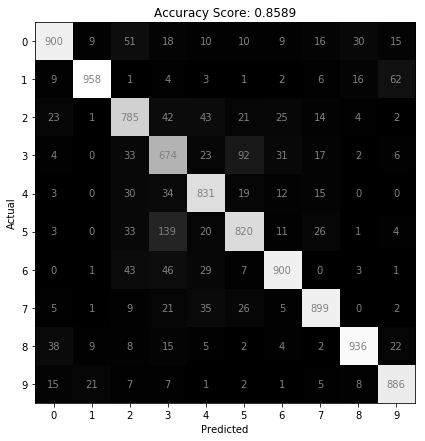

In [13]:
runner.validate(metrics=[ConfusionMatrix(plot=True, classes=10)])

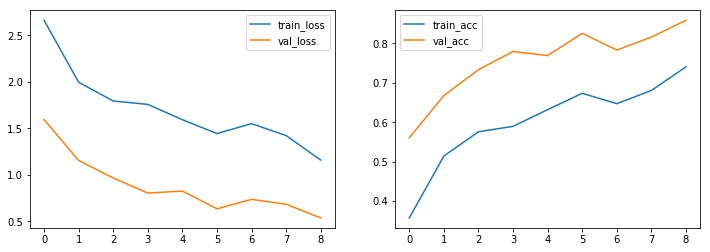

In [14]:
runner.history(plot=True)